In [8]:
import numpy as np
import pandas as pd
import mne
from pymeg import source_reconstruction as sr
from pymeg import lcmv 
from pymeg import preprocessing as prep

In [3]:
# variables:
subj = 'jw02'
sr.set_fs_subjects_dir('/home/degee/pymeg_test/')
raw_filename = '/home/degee/pymeg_test/JW2_JWDet_20141115_03.ds'
epoch_filename = '/home/degee/pymeg_test/test-epo.fif.gz'
trans_filename = '/home/degee/pymeg_test/jw02_A-trans.fif' 
meta_filename = '/home/degee/pymeg_test/test-meta.hdf' 

In [ ]:
# make transformation matrix:
sr.make_trans(subj, raw_filename, epoch_filename, trans_filename)

In [4]:
# load epochs:
epochs = mne.read_epochs(epoch_filename)
epochs = epochs.pick_channels([x for x in epochs.ch_names if x.startswith('M')])
epochs.apply_baseline((-0.3,-0.2))

# load meta data:
meta = pd.concat(prep.load_meta([meta_filename]))

Reading /home/degee/pymeg_test/test-epo.fif.gz ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        5 CTF compensation matrices available
517 matching events found
No baseline correction applied
517 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


In [6]:
# get lead field:
forward, bem, source = sr.get_leadfield(subj, raw_filename, epoch_filename, trans_filename)

<Forward | MEG channels: 268 | EEG channels: 0 | Source space: Surface with 7497 vertices | Source orientation: Free>


In [9]:
# do source reconstruction:

def get_F_estimator(sf=600, decim=10):
    fois = np.arange(4,162,2)
    cycles = 0.4 * fois
    tb = 6
    return ('F', fois, lcmv.get_power_estimator(fois, cycles, tb, sf=sf, decim=decim))

def get_broadband_estimator():
    return ('BB', [-1], lambda x: x[:, np.newaxis, :])

data_cov = lcmv.get_cov(epochs, tmin=0, tmax=1)
noise_cov = None
labels = sr.get_labels(subj, ['*BA*.label'])
res = lcmv.do_epochs(epochs, meta, forward, source, noise_cov, data_cov, labels, 
                        func=[get_F_estimator(), get_broadband_estimator()], accumulator=None)

    268 out of 268 channels remain after picking
Processing epoch : 1
Running F on trial 11925


[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 232 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 592 tasks      | elapsed:    7.9s


KeyboardInterrupt: 

In [33]:
nvertex = 3500*2
nfreq = 40
ntrials = 1000
sec = 2
hz = 60
nsub = 15
ntls = 2
to_gb = 8/(1024*1024*1024)
gbytes = ntls*nsub*(nvertex*nfreq*ntrials*sec*hz)*to_gb

def gbytes(nvertex=3500*2, nfreq=40, nsub=15, ntrials=1000, hz=60, sec=2, ntls=2):
    return ntls*nsub*(nvertex*nfreq*ntrials*sec*hz)*to_gb

In [9]:
gbytes

7510.185241699219

In [13]:
spaces = {'oct5':1026,# 	9.9 	97
'ico4':2562,# 	6.2 	39
'oct6':4098,# 	4.9 	24
'ico5':10242}# 	3.1 	9.8}

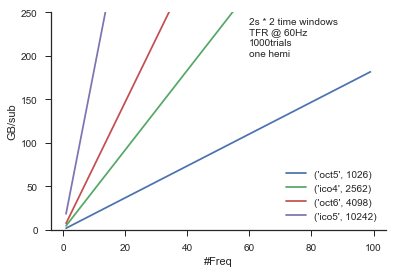

In [31]:
import seaborn as sns
sns.set_style('ticks')
import numpy as np
import pylab as plt
%matplotlib inline
nfreq = np.arange(1, 100)
for n, i in spaces.items():
    plt.plot(nfreq, gbytes(nfreq=nfreq, nvertex=i, nsub=1), label=str((n, i)))
plt.legend()
plt.ylim([0, 250])
plt.ylabel('GB/sub')
plt.xlabel('#Freq')
plt.text(60,200, '2s * 2 time windows\nTFR @ 60Hz\n1000trials\none hemi')
sns.despine()
plt.savefig('/Users/nwilming/Desktop/space_req.pdf')

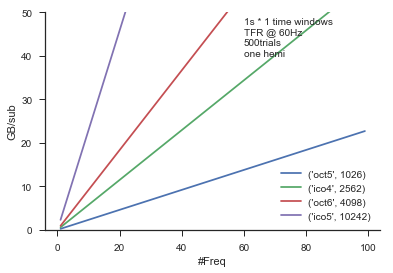

In [37]:
import seaborn as sns
sns.set_style('ticks')
import numpy as np
import pylab as plt
%matplotlib inline
nfreq = np.arange(1, 100)
for n, i in spaces.items():
    plt.plot(nfreq, gbytes(nfreq=nfreq, nvertex=i, nsub=1, ntrials=500, sec=1, ntls=1), label=str((n, i)))
plt.legend()
plt.ylim([0, 50])
plt.ylabel('GB/sub')
plt.xlabel('#Freq')
plt.text(60, 40, '1s * 1 time windows\nTFR @ 60Hz\n500trials\none hemi')
sns.despine()
plt.savefig('/Users/nwilming/Desktop/space_req_opt.pdf')